<a href="https://colab.research.google.com/github/MahdiEsrafili/image_segmentation/blob/master/bacterial_segmentaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
% cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d longnguyen2306/bacteria-detection-with-darkfield-microscopy

 93% 150M/162M [00:01<00:00, 93.4MB/s]
100% 162M/162M [00:01<00:00, 108MB/s] 


In [ ]:
!unzip bacteria-detection-with-darkfield-microscopy.zip -d data/

Archive:  bacteria-detection-with-darkfield-microscopy.zip
  inflating: data/images/001.png     
  inflating: data/images/002.png     
  inflating: data/images/003.png     
  inflating: data/images/004.png     
  inflating: data/images/005.png     
  inflating: data/images/006.png     
  inflating: data/images/007.png     
  inflating: data/images/008.png     
  inflating: data/images/009.png     
  inflating: data/images/010.png     
  inflating: data/images/011.png     
  inflating: data/images/012.png     
  inflating: data/images/013.png     
  inflating: data/images/014.png     
  inflating: data/images/015.png     
  inflating: data/images/016.png     
  inflating: data/images/017.png     
  inflating: data/images/018.png     
  inflating: data/images/019.png     
  inflating: data/images/020.png     
  inflating: data/images/021.png     
  inflating: data/images/022.png     
  inflating: data/images/023.png     
  inflating: data/images/024.png     
  inflating: data/images/025.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import os
import random
from PIL import Image
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

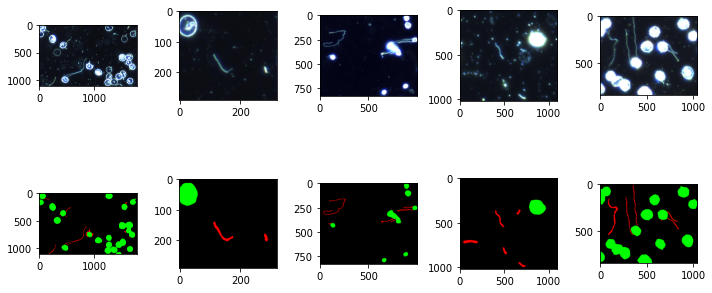

In [ ]:
plt.figure(figsize=(10, 5))
idxs = np.random.randint(1, 366, size=5)
for n, i in enumerate(idxs):
  idx = '{:03}'.format(i)
  img = cv2.imread(f'data/images/{idx}.png')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  mask = cv2.imread(f'data/masks/{idx}.png')
  mask[:,:,0] = np.where(mask[:,:,0]==2, 255, mask[:,:,0])
  mask[:,:,1] = np.where(mask[:,:,1]==1, 255, mask[:,:,1])
  plt.subplot(2, 5, n+1)
  plt.imshow(img)
  plt.subplot(2, 5, 5+n+1)
  plt.imshow(mask)

plt.tight_layout()

In [ ]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from torchvision import models
from tqdm.notebook import tqdm
import torchvision
import torch

In [ ]:
img_dir = '/content/data/images'
files = os.listdir(img_dir)
random.shuffle(files)
train_test_ratio = 0.7
split_idx = int(len(files) * train_test_ratio)
train_id = files[:split_idx]
test_id = files[split_idx:]

In [ ]:
# for f in files:
#   img = cv2.imread(f'/content/data/images/{f}')
#   print(img.shape)

In [ ]:
train_id.__len__(), test_id.__len__()

(256, 110)

In [ ]:
class BacterialDS(Dataset):
  def __init__(self, ids, path, transforms=None):
    self.ids = ids
    self.path = path
    self.transforms = transforms

  def __len__(self):
    return len(self.ids)
  
  def __getitem__(self, idx):
    img_path = os.path.join(self.path, 'images', self.ids[idx])
    mask_path = os.path.join(self.path, 'masks', self.ids[idx])
    img = Image.open(img_path)
    mask = torchvision.io.read_image(mask_path)[0].unsqueeze(0)
    if self.transforms:
      img = self.transforms['image'](img)
      mask = self.transforms['mask'](mask)
    return img, mask

In [ ]:
img_transforms = T.Compose([
                        T.Resize((480, 480)),
                        T.ToTensor()                        
])
mask_transforms = T.Compose([
                        T.Resize((480, 480)),                 
])
transforms = {
    'image' : img_transforms,
    'mask' : mask_transforms
}

In [ ]:
path = '/content/data'
train_dataset = BacterialDS(train_id, path, transforms)
test_dataset = BacterialDS(test_id, path, transforms)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size)
test_loader = DataLoader(test_dataset, batch_size)

In [ ]:
model = models.segmentation.deeplabv3_resnet50(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


In [ ]:
model.classifier = models.segmentation.deeplabv3.DeepLabHead(2048, 3)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model = model.train().to(device)

In [ ]:
def train(model, optimizer, criterion, lr_scheduler, dataloaders, num_epochs=10):
  model.train()
  loss_history = list()
  num_epochs=10
  for epoch in range(num_epochs):
    pbar = tqdm(dataloaders['train'])
    epoch_losses = np.array([])
    for (images, masks) in pbar:
      images = images.to(device, dtype=torch.float)
      masks = masks.to(device, dtype=torch.long).view(-1, masks.size(2), masks.size(3))
      optimizer.zero_grad()
      out = model(images)
      loss = criterion(out['out'], masks)
      loss.backward()
      optimizer.step()
      epoch_losses = np.append(epoch_losses, loss.item())
      pbar.set_description(f'epoch {epoch+1}/{num_epochs},\
                            loss= {epoch_losses.mean():.4f}')
    loss_history.append(epoch_losses.mean())
    lr_scheduler.step()
    return loss_history
      

In [ ]:
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [ ]:
dataloaders = {'train': train_loader,
               'test': test_loader}

In [ ]:
train(model, optimizer, criterion, lr_scheduler, dataloaders)

KeyboardInterrupt: ignored

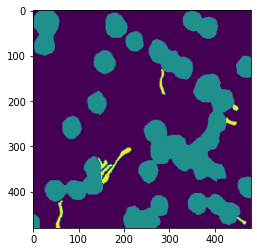

In [ ]:
plt.imshow(masks[0])

In [ ]:
with torch.no_grad():
  results = []
  ground_truth = []
  model.eval()
  for (imges, masks) in test_loader:
    images = images.to(device)
    preds = model(images)
    results.append(preds['out'].cpu())

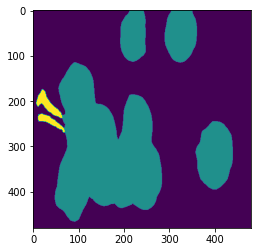

In [ ]:
c = results[3][3]
cm = c.argmax(dim=0)
plt.imshow(cm)